In [214]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn
from google.colab import files

In [215]:
random.seed(4)

## Generate Data Points

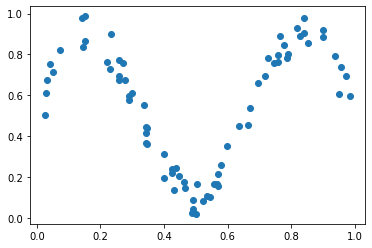

In [230]:
sample_size = 75
X = np.random.uniform(0,1, [sample_size,1])
h = 0.5 + 0.4 * np.sin(3*np.pi*X) + np.random.uniform(-0.1, 0.1, [sample_size,1])
plt.scatter(X,h)
plt.show()

##K-Means

In [231]:
def findClosestCentroid(X, centroids):
  idx = np.zeros((sample_size, 1))
  for i in range(sample_size):
    idx[i] = np.argmin(np.linalg.norm(X[i] - centroids, axis= 1)) #assign x to its closest centroid
  return idx

In [232]:
def computeCentroids(X, idx, K):
  centroids = np.zeros((K, X.shape[1]))
  for k in range(K):
    C_K = (idx == k) #find all points belonging to cluster k
    centroids[k] = np.mean(X[C_K.ravel()], axis = 0) #update centroid of cluster k
  return centroids

In [219]:
def plot_Kmeans(X, centroids, previous, idx, K): #plot the data points according to the clusters they are assigned to
  plt.figure(figsize=[15,5])
  plt.scatter(X ,h, c=idx)
  plt.xlabel('x')
  plt.ylabel('h(x)')
  plt.title("k= {}".format(K))
  # plt.plot(h, '*')

In [220]:
def runKmeans(X, K, init_centroids, max_iters):
  centroids = init_centroids
  previous_centroids = centroids
  for i in range(max_iters):
     idx = findClosestCentroid(X, centroids) #update label of points to its closest centroid
    #  print(idx)
     centroids = computeCentroids(X, idx, K) #update the centroids
    #  print(centroids)
     if np.linalg.norm(previous_centroids - centroids, 1) == 0: #if previous centroid = current centroid k-means has converged
       print("K-Means converged at i = {}".format(i))
       break
     else:
       previous_centroids = centroids
  # print(idx)
  plot_Kmeans(X, centroids, previous_centroids, idx, K)
  return centroids, idx

##Gaussian RBF nodes

Here the width of the gaussian node is the variance of the points belonging to the node

In [233]:
def gaussian_rbf_create(K):

  random_idx = random.sample(range(sample_size),K)
  centroids, idx = runKmeans(X, K, X[random_idx], 100)
  cluster_var = []

  for k in range(K):
    points = X[(idx==k).ravel()]
    var = np.mean(np.linalg.norm(points - centroids[k], axis=1)**2, axis =0) #compute variance based on the points in that cluster
    cluster_var.append(var)
  #if any of the cluster var is zero i.e it has only one point, 
  #set the variance of the cluster as the mean of the other cluster variances
  for i in range(K): 
    if cluster_var[i] == 0:
      cluster_var[i] = np.sum(cluster_var)/ np.count_nonzero(cluster_var)
  rbf_input = np.zeros((sample_size, K))

  for k in range(K):
    norm = np.linalg.norm(X - centroids[k], axis = 1)**2 # G = exp(-0.5*(dist from centroid)/var)
    rbf_input[:,k] = np.exp(-0.5 * norm / cluster_var[k])
  return  rbf_input, centroids, cluster_var

In [222]:
def Linear_Regression(eta, K, rbf_input):
  w = np.random.uniform(low = -0.1, high = 0.1, size=(K+1,1)) #initialize random weights
  error_arr = []
  for epoch in range(100):
    error_sum = 0
    for sample in range(sample_size):
      augmented_rbf = np.vstack((1, rbf_input[sample].reshape(K,1))) #augment the input
      w = w + eta * (h[sample] - w.T @ augmented_rbf) * augmented_rbf #LMS update rule
      error = 0.5 * (h[sample] - w.T @ augmented_rbf)**2 #error function
      error_sum = error_sum + error[0,0]
    error_arr.append(error_sum/sample_size)
  plt.plot(error_arr, label = "eta = {} K = {}".format(eta, K)) #plot the error
  plt.xlabel("epoch")
  plt.ylabel("training error")
  plt.title("training error vs number of epochs")
  plt.legend()
  return w


In [223]:
def plot_fit(w, centroids, eta, cluster_var):
  plt.figure(figsize=[10,5])
  # plt.subplot(2,1,1)
  x_test = np.linspace(0,1,10*sample_size).reshape(10*sample_size,1) #take samples of x
  y_test=0.5 + 0.4 * np.sin(3*np.pi*x_test) #actual value for input x
  # data_set = np.hstack((x_test,y_test))
  data_set = x_test
  rbf_input_test = np.zeros((10*sample_size, len(centroids)))
  for k in range(len(centroids)): #calculate the k gaussians for every x
    norm = np.linalg.norm(data_set - centroids[k], axis = 1)**2
    rbf_input_test[:,k] = np.exp(-0.5 * norm / cluster_var[k])
  
  plt.figure()
  temp = w.T * np.hstack((np.ones((10*sample_size,1)), rbf_input_test))
  for k in range(len(centroids) +1 ):
    plt.plot(x_test, temp[:,k]) #plot gaussians
  y_fit = np.sum(w.T * np.hstack((np.ones((10*sample_size,1)), rbf_input_test)), axis=1) #estimate y from the computed weights
  plt.plot(x_test, y_fit, '--', label = 'Fit function')
  plt.xlabel("x")
  plt.ylabel("gaussian rbf")
  plt.title("Generated Gaussians for {} rbf nodes".format(len(centroids)))
  plt.legend()
  
  plt.figure()
  plt.plot(X,h, '+' , x_test,y_test,  x_test, y_fit, '--')
  plt.xlabel("x")
  plt.ylabel("h(x)")
  plt.title("results for eta = {} number of bases = {}".format(eta, len(centroids)))
  plt.legend(['sampled data', 'original function','fit function'])
  

K-Means converged at i = 4
K-Means converged at i = 4
K-Means converged at i = 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

K-Means converged at i = 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

K-Means converged at i = 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

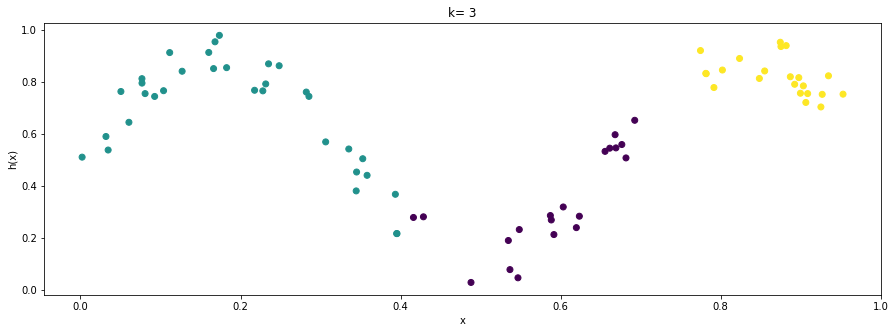

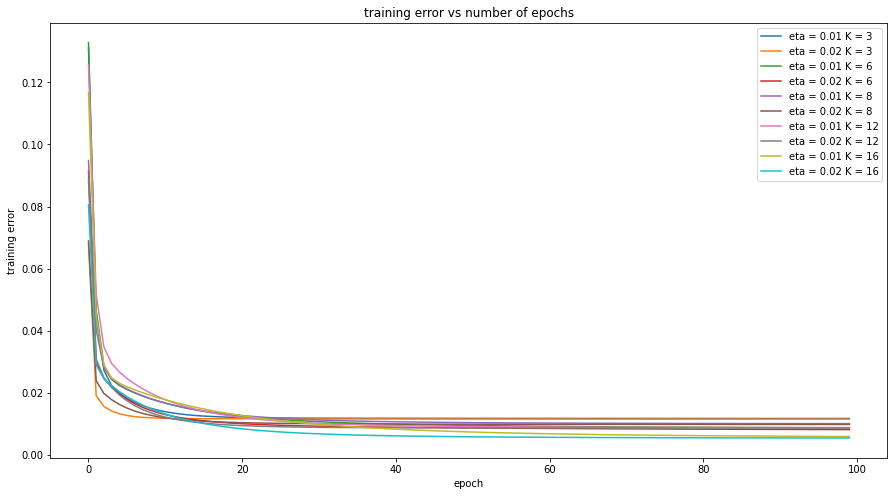

<Figure size 720x360 with 0 Axes>

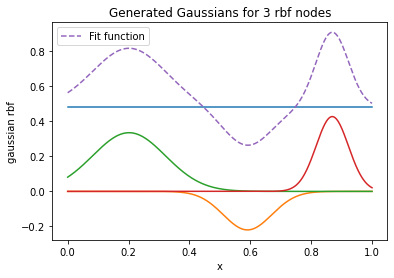

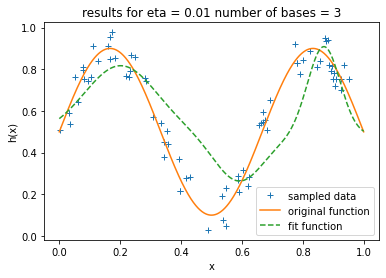

<Figure size 720x360 with 0 Axes>

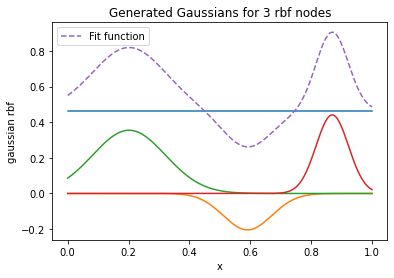

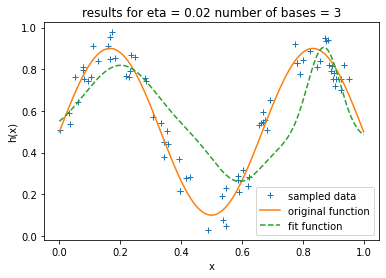

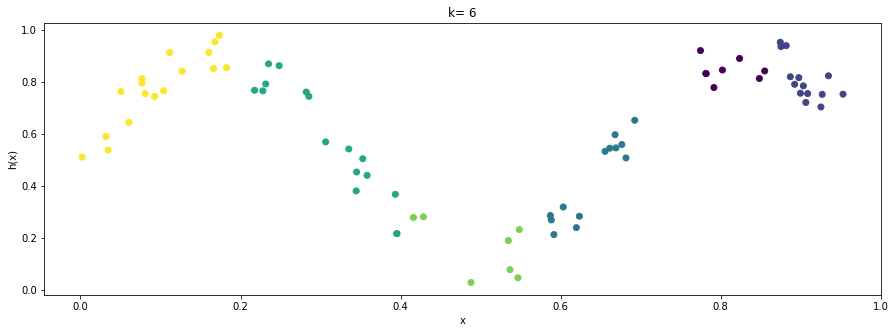

<Figure size 720x360 with 0 Axes>

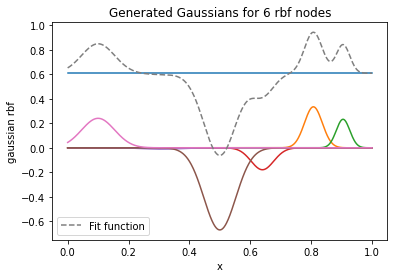

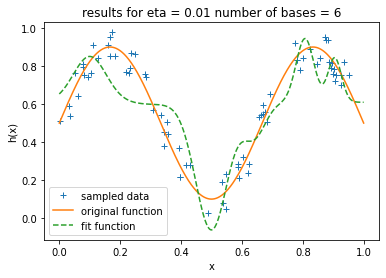

<Figure size 720x360 with 0 Axes>

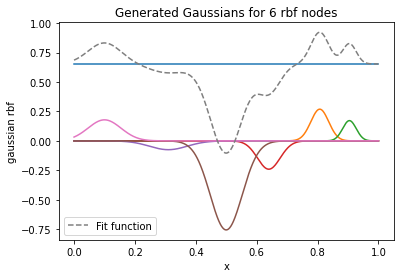

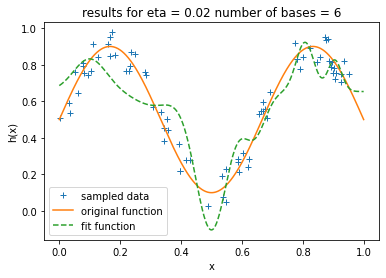

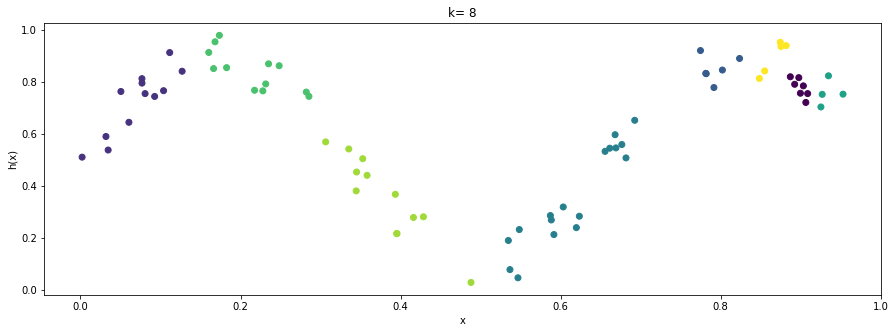

<Figure size 720x360 with 0 Axes>

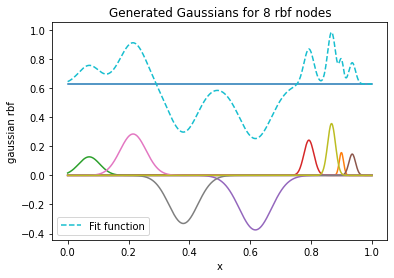

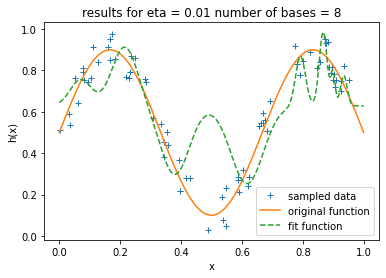

<Figure size 720x360 with 0 Axes>

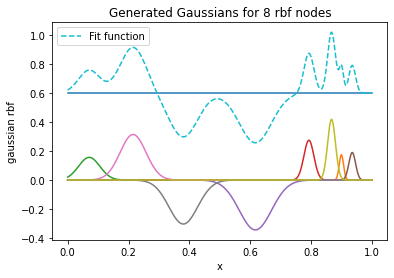

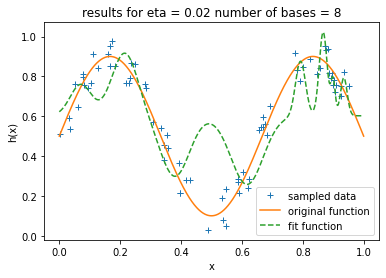

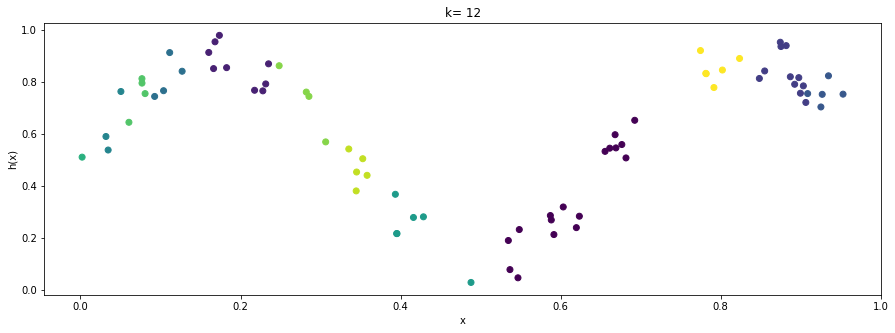

<Figure size 720x360 with 0 Axes>

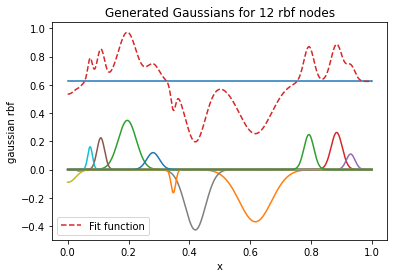

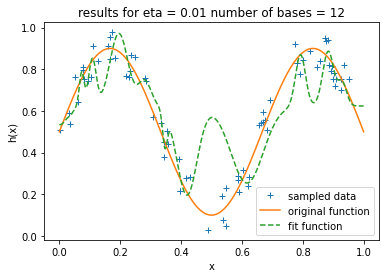

<Figure size 720x360 with 0 Axes>

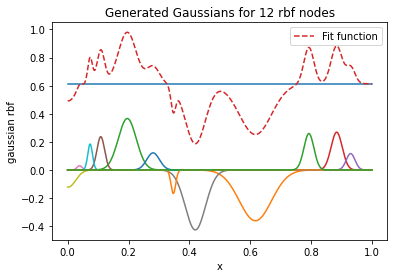

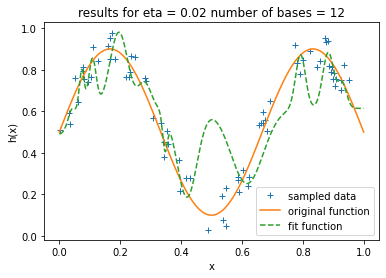

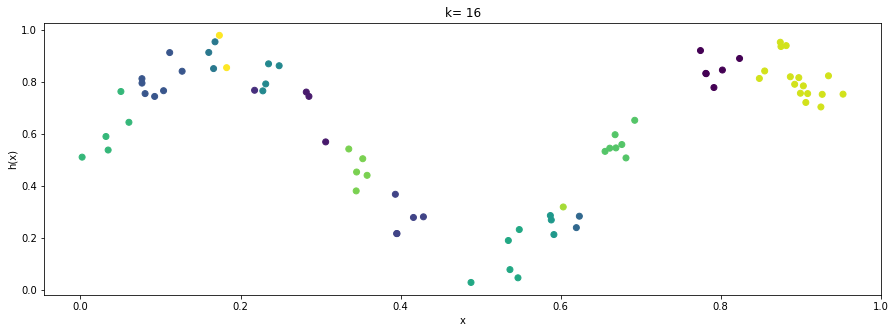

<Figure size 720x360 with 0 Axes>

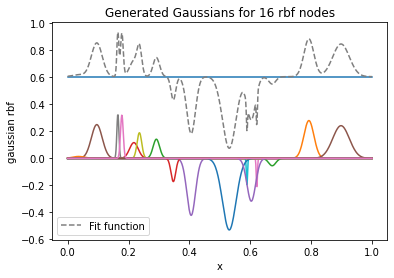

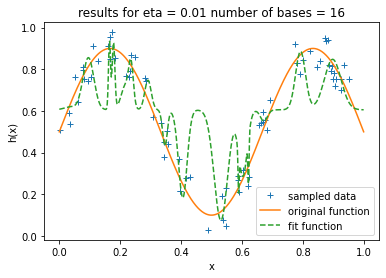

<Figure size 720x360 with 0 Axes>

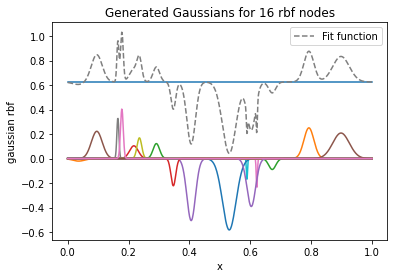

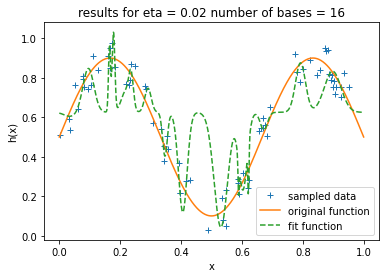

In [224]:
for k in [3,6,8,12,16]:
  rbf_input, centroids, cluster_var = gaussian_rbf_create(k)
  for eta in [0.01, 0.02]:
    plt.figure(0, figsize=[15,8])
    w = Linear_Regression(eta, k, rbf_input)
    plot_fit(w, centroids, eta, cluster_var)


## Gaussian  RBFs with the same width

Here the width of the gaussian node is the maximum distance between the clusters

In [225]:
def gaussian_rbf_create_sigma(K):

  random_idx = random.sample(range(sample_size),K)
  centroids, idx = runKmeans(X, K, X[random_idx], 100)

  from itertools import combinations 
  d_max  = -1
  for pair in combinations(centroids,2): #for all pairs of centroids
    if np.linalg.norm(pair[0] - pair[1]) > d_max: #find the pair that has the max distance
      d_max = np.linalg.norm(pair[0] - pair[1])
      max_pair = pair
  
  var = d_max**2 / (2*K) #variance of all gaussian nodes = d_max*d_max/2K
  cluster_var = [var]*K
  rbf_input = np.zeros((sample_size, K))
  for k in range(K):
    norm = np.linalg.norm(X - centroids[k], axis = 1)**2 #find the Gaussian RBF values for all inputs
    rbf_input[:,k] = np.exp(-0.5 * norm / cluster_var[k])

  return  rbf_input, centroids, cluster_var

K-Means converged at i = 10
K-Means converged at i = 7
K-Means converged at i = 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

K-Means converged at i = 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

K-Means converged at i = 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

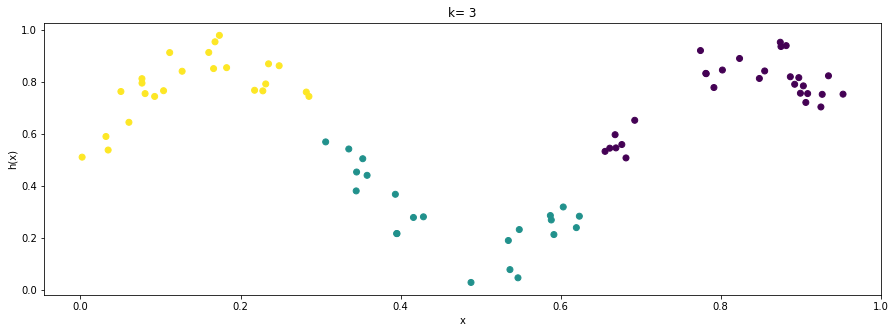

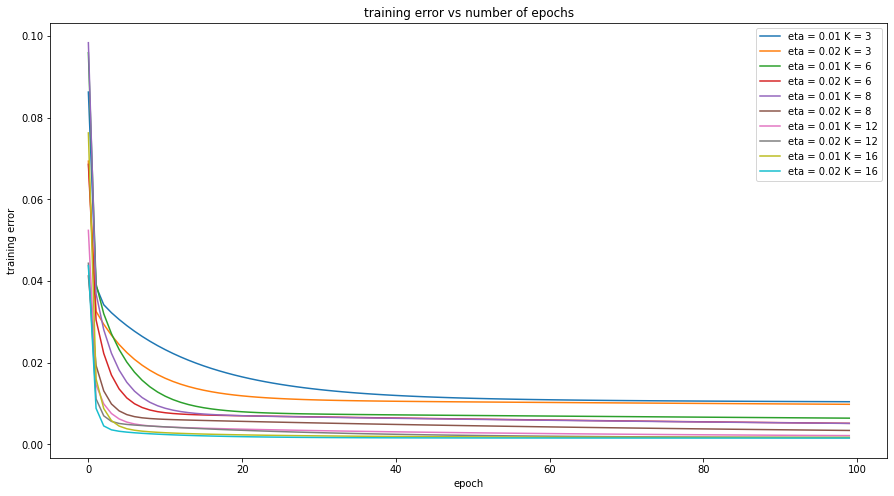

<Figure size 720x360 with 0 Axes>

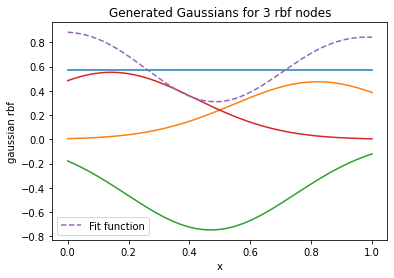

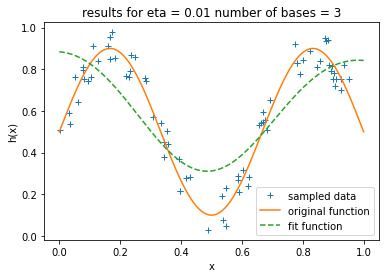

<Figure size 720x360 with 0 Axes>

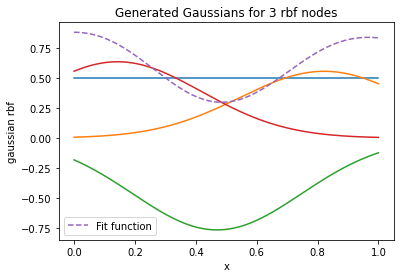

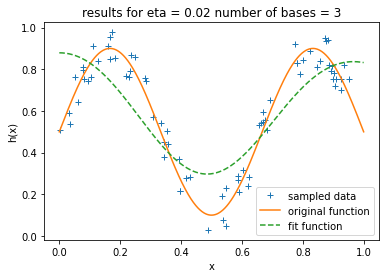

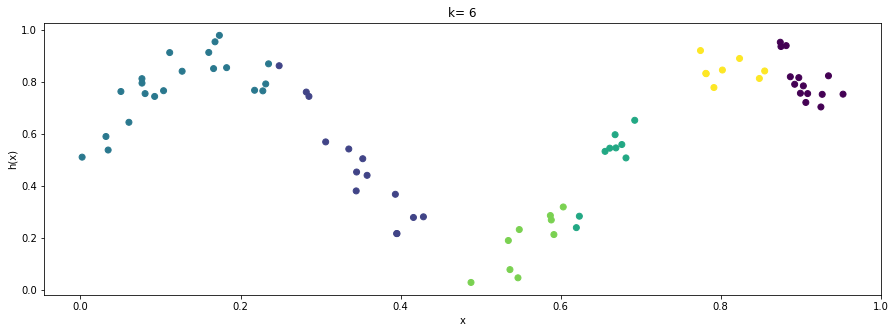

<Figure size 720x360 with 0 Axes>

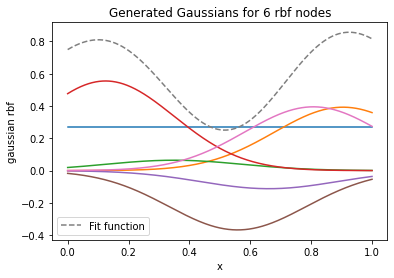

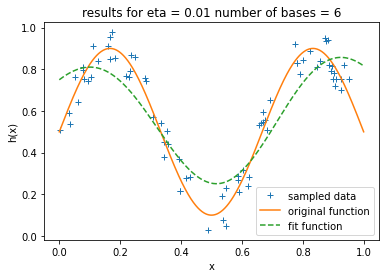

<Figure size 720x360 with 0 Axes>

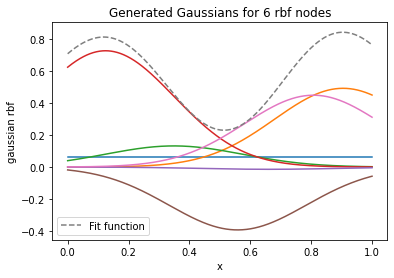

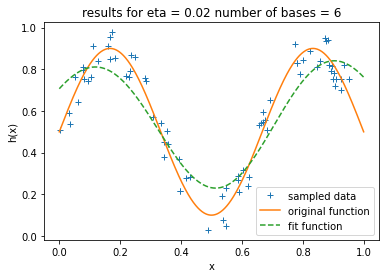

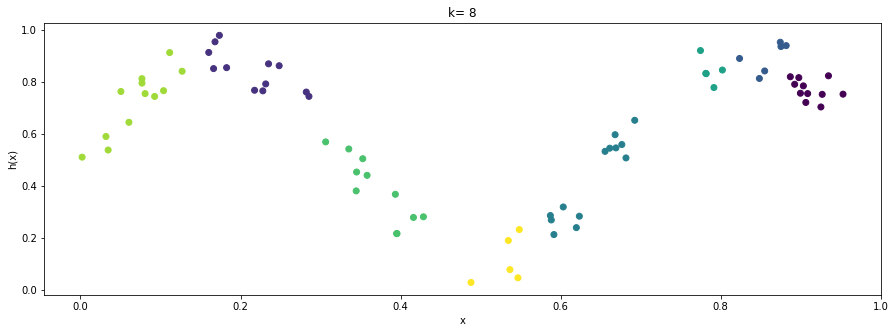

<Figure size 720x360 with 0 Axes>

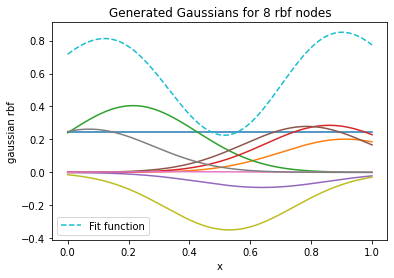

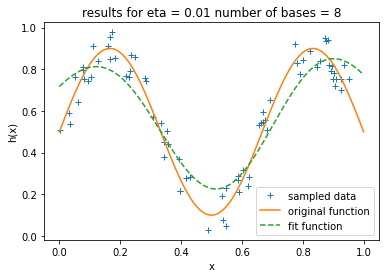

<Figure size 720x360 with 0 Axes>

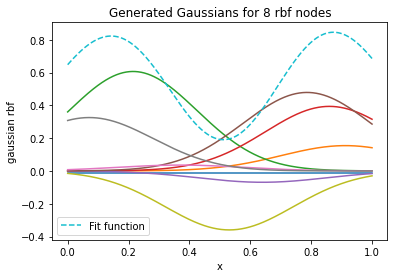

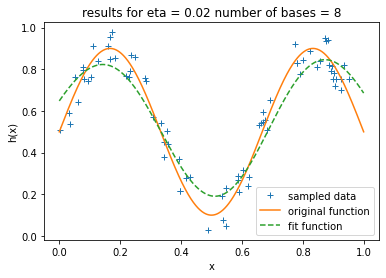

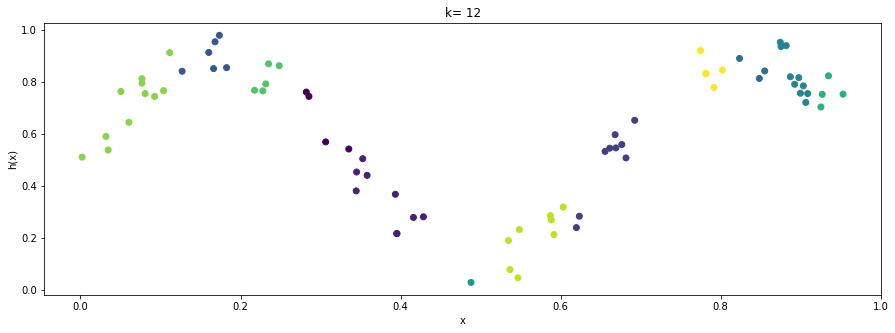

<Figure size 720x360 with 0 Axes>

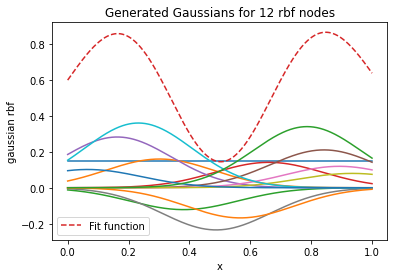

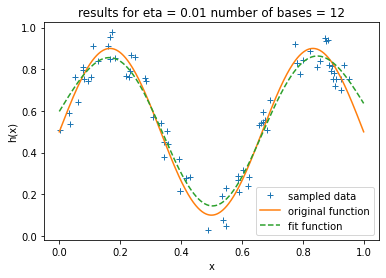

<Figure size 720x360 with 0 Axes>

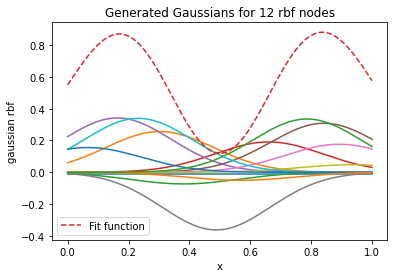

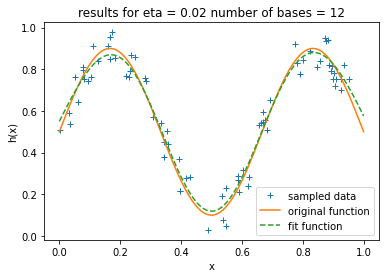

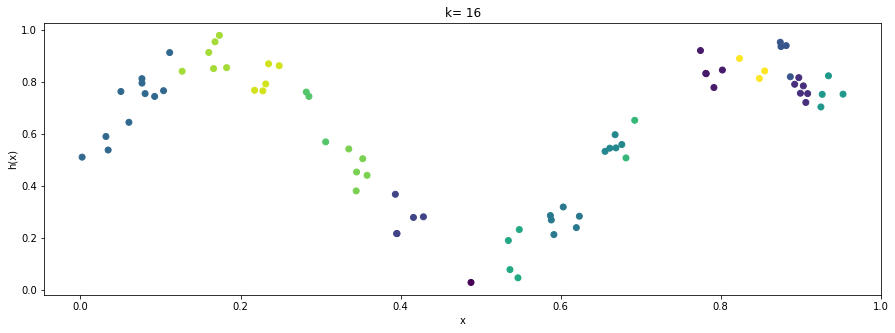

<Figure size 720x360 with 0 Axes>

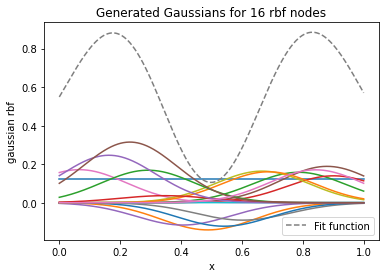

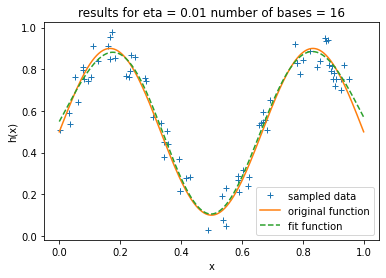

<Figure size 720x360 with 0 Axes>

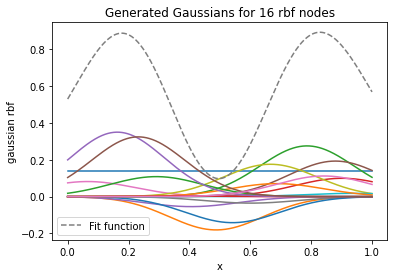

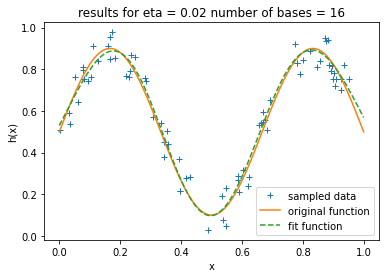

In [226]:
for k in [3,6,8,12,16]:
  rbf_input, centroids, cluster_var = gaussian_rbf_create_sigma(k)
  for eta in [0.01, 0.02]:
    plt.figure(0, figsize=[15,8])
    w = Linear_Regression(eta, k, rbf_input)
    plot_fit(w, centroids, eta, cluster_var)

K-Means converged at i = 2
K-Means converged at i = 8


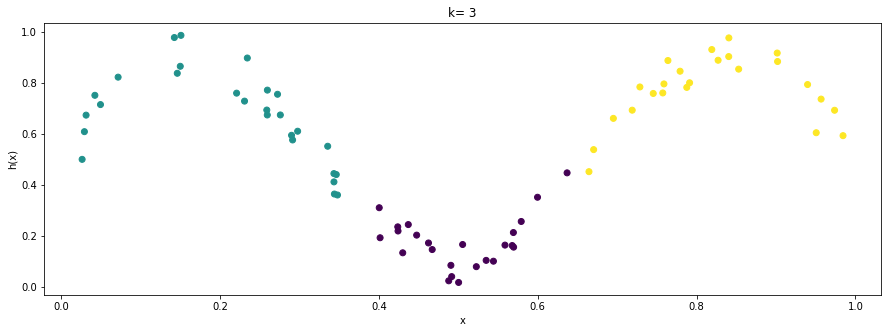

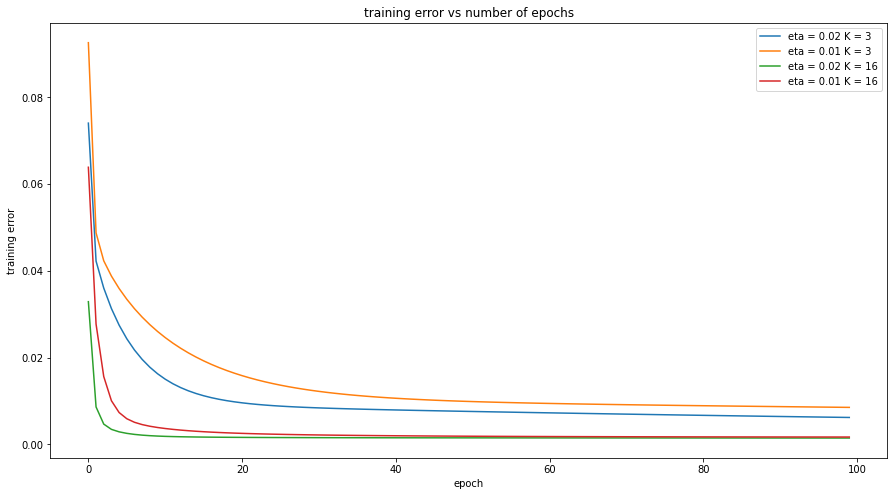

<Figure size 720x360 with 0 Axes>

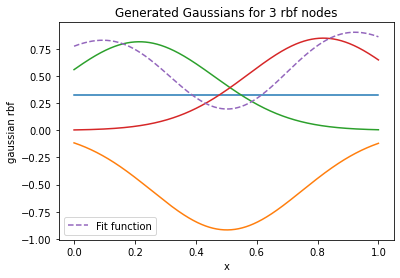

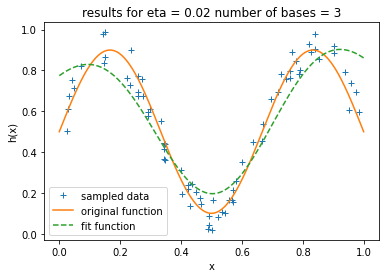

<Figure size 720x360 with 0 Axes>

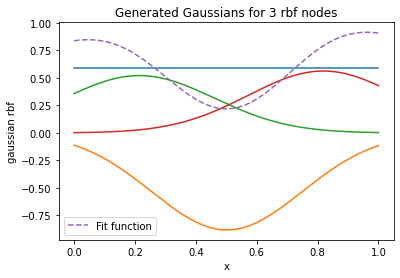

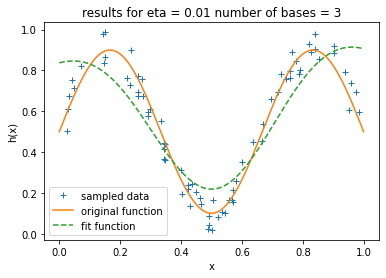

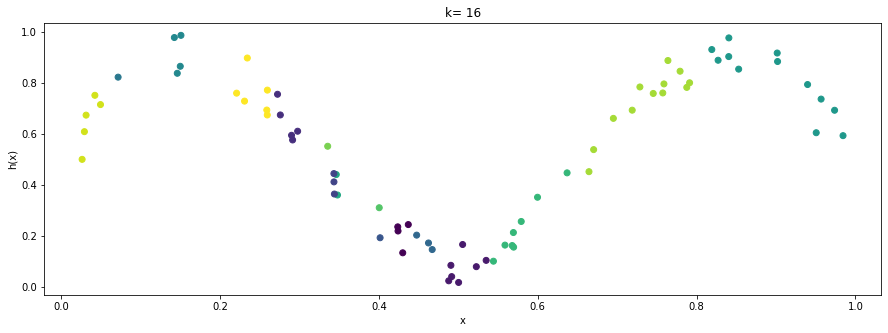

<Figure size 720x360 with 0 Axes>

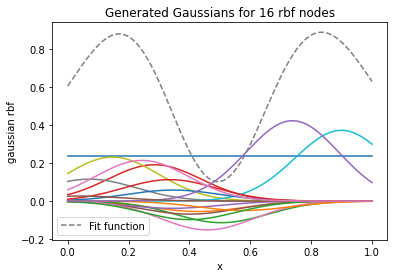

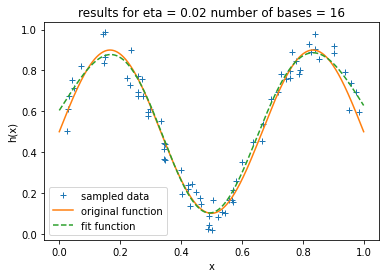

<Figure size 720x360 with 0 Axes>

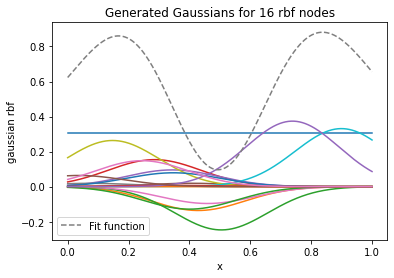

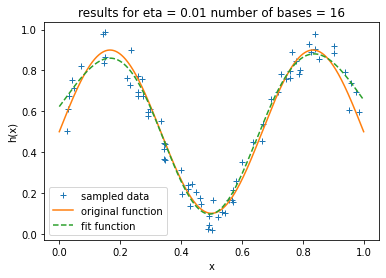

In [245]:
for k in [3,16]:
  rbf_input, centroids, cluster_var = gaussian_rbf_create_sigma(k)
  for eta in [0.02, 0.01]:
    plt.figure(0, figsize=[15,8])
    w = Linear_Regression(eta, k, rbf_input)
    plot_fit(w, centroids, eta, cluster_var)

K-Means converged at i = 5


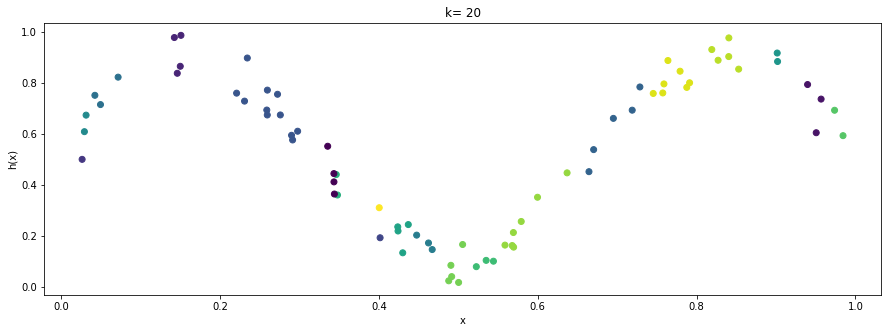

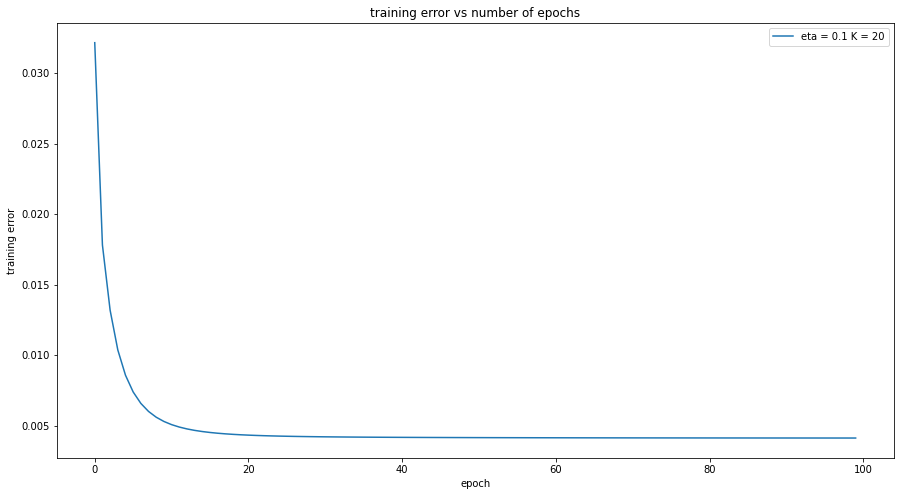

<Figure size 720x360 with 0 Axes>

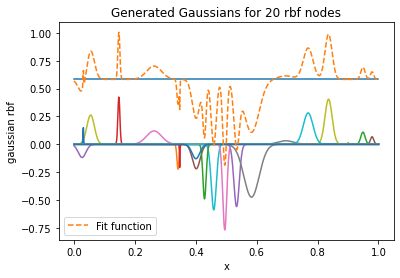

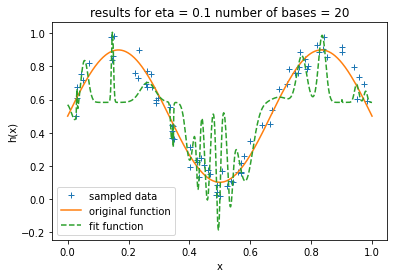

In [234]:
for k in [20]:
  rbf_input, centroids, cluster_var = gaussian_rbf_create(k)
  for eta in [0.1]:
    plt.figure(0, figsize=[15,8])
    w = Linear_Regression(eta, k, rbf_input)
    plot_fit(w, centroids, eta, cluster_var)